In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb, simple_norm
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder

In [4]:
df_candidates = pd.read_csv('./data/candidates/candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
len(gr)

13576

In [5]:
source_id = 30885280

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


 id xcentroid ycentroid sharpness ...  peak    flux    mag   daofind_mag
--- --------- --------- --------- ... ----- --------- ------ -----------
  1     110.4     23.25    0.4822 ... 237.9      2073 -8.291      -1.047
  2     52.43      36.9     0.497 ... 235.5      2072 -8.291      -1.011
  3     53.29      52.4    0.5301 ... 562.4      7094 -9.627      -1.681
  4     59.51     52.39    0.4704 ... 465.5      9103 -9.898     -0.9392
  5     20.24     52.94     0.542 ... 533.2      4226 -9.065      -1.889
  6     36.34     55.88    0.5052 ... 853.5      7405 -9.674        -2.4
  7     56.86     55.93    0.5058 ...  3897 4.069e+04 -11.52      -3.889
  8      59.3     75.77    0.5388 ... 265.8      1695 -8.073      -1.247
  9     63.33     77.65    0.6812 ... 298.5      1744 -8.104      -1.293
 10     66.81     79.65    0.9023 ... 546.2      2389 -8.446      -1.797
 11     73.94     109.4    0.4667 ... 101.7     834.9 -7.304     -0.1726
(array([52.75193884, 58.09645026, 57.20273397]), ar

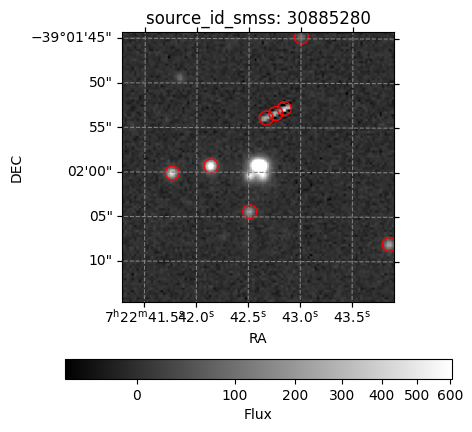

In [6]:
group = gr.get_group(source_id)
band = 'r'
hdul_r = fits.open(f"data/candidates/fits2/{band}/{source_id}_{band}.fits")
w_r = WCS(hdul_r[0].header)
data_r = hdul_r[0].data
header_r = hdul_r[0].header
hdul_r.close()

mean, median, std = sigma_clipped_stats(data_r, sigma=3.0)  
daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)  
data_r -= median
sources = daofind(data_r)
for col in sources.colnames:  
    sources[col].info.format = '%.4g'
print(sources)
x_centroid = np.array(sources['xcentroid'])
y_centroid = np.array(sources['ycentroid'])

gaia_pix = w_r.world_to_pixel_values(group['ra_gaia'], group['dec_gaia'])
print(gaia_pix)

addsources = []
for i, (x, y) in enumerate(zip(x_centroid, y_centroid)):
    if np.any(np.sqrt((x - gaia_pix[0])**2 + (y - gaia_pix[1])**2) < 4):
        print(f"Source {i} is in Gaia")
    else:
        addsources.append(sources[i])
print(f"Added {len(addsources)} sources")

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection=w_r)
norm = simple_norm(data_r, 'sqrt', percent=99.5)
cb = ax.imshow(data_r, origin='lower', cmap='gray', norm=norm)
for source in addsources:
    ax.scatter(source['xcentroid'], source['ycentroid'], s=100, edgecolor='red', facecolor='none',
               transform=ax.get_transform(w_r))
ax.coords.grid(color='white', linestyle='solid')
ax.coords['ra'].set_axislabel('RA')
ax.coords['dec'].set_axislabel('DEC')
ax.set_title(f'source_id_smss: {source_id}')
plt.grid(True, color='gray', linestyle='--')
plt.colorbar(cb, label='Flux', orientation='horizontal')
plt.show()

07h22m42.59592s -39d01m59.3544s
110.677 -39.0332


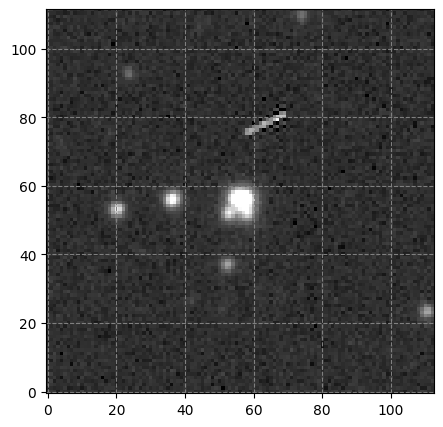

In [52]:
plt.figure(figsize=(5, 5))
norm = simple_norm(data_r, 'sqrt', percent=99.5)
plt.imshow(data_r, origin='lower', cmap='gray', norm=norm)
plt.grid(True, color='gray', linestyle='--')
coords = SkyCoord(ra=group.iloc[0]['ra_smss'], 
                  dec=group.iloc[0]['dec_smss'], 
                  unit=(u.deg, u.deg))
print(coords.to_string('hmsdms'))
print(coords.to_string('decimal'))

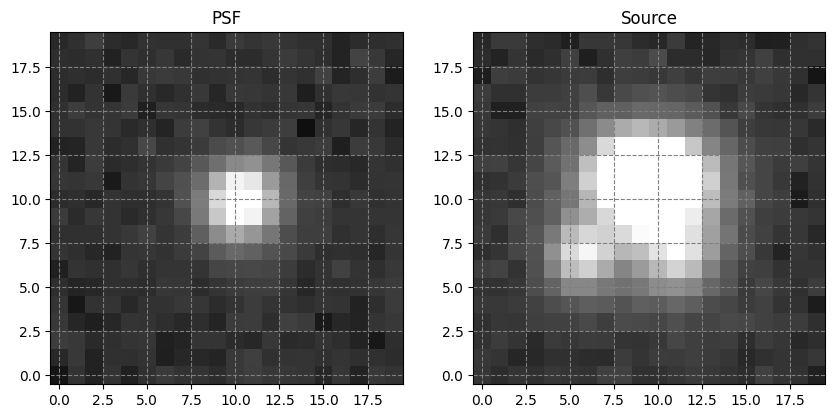

In [8]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
psf = Cutout2D(data_r.data, (36, 56), size=(20, 20))
ax1.imshow(psf.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('PSF')
ax2 = plt.subplot(122)
src = Cutout2D(data_r.data, (57, 55), size=(20, 20))
ax2.imshow(src.data, origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Source')
plt.show()

# Fitting PSF

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const2D(amplitude=-1.12187569)>

    [1]: <Moffat2D(amplitude=942.36592158, x_0=10.32497618, y_0=9.8824871, gamma=2.22878538, alpha=2.5)>
Parameters:
        amplitude_0        amplitude_1    ...      gamma_1      alpha_1
    ------------------- ----------------- ... ----------------- -------
    -1.1218756859070824 942.3659215816025 ... 2.228785381765542     2.5


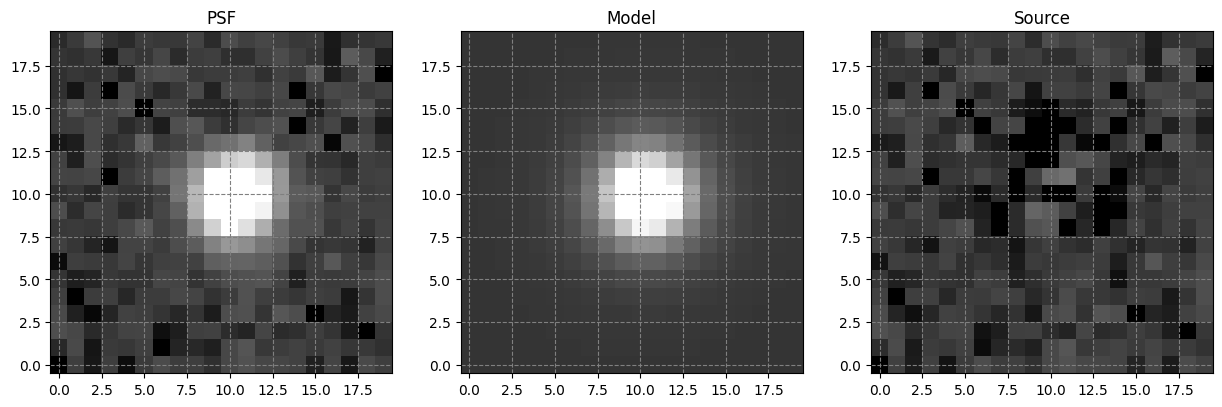

In [9]:
fit_r = fitting.LevMarLSQFitter()
model_init = models.Const2D(amplitude=0.0,
                            # fixed={'amplitude': True}
                            )
model_init += models.Moffat2D(amplitude=psf.data.max(),
                                 x_0=psf.center_cutout[0],
                                 y_0=psf.center_cutout[1],
                                 gamma=2.5,
                                 alpha=2.5,
                                 fixed={'alpha': True}
                                 )
y, x = np.mgrid[:20, :20]
model_psf = fit_r(model_init, x, y, psf.data)
print(model_psf)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
norm = simple_norm(psf.data, 'sqrt', percent=95.0)
ax1.imshow(psf.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('PSF')
ax2 = fig.add_subplot(132)
ax2.imshow(model_psf(x, y), origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
residual = psf.data - model_psf(x, y)
ax3.imshow(residual, origin='lower', cmap='gray', norm=norm)
ax3.grid(True, color='gray', linestyle='--')
ax3.set_title('Source')
plt.show()

# Fitting source images with PSF model

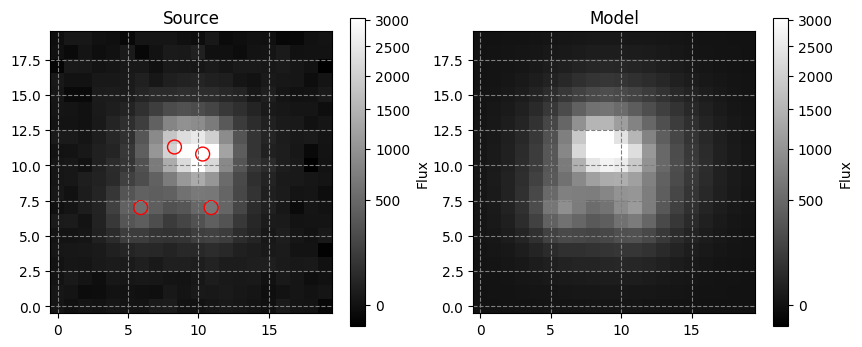

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const2D(amplitude=0., name='const')>

    [1]: <Moffat2D(amplitude=3896.9921875, x_0=8.3, y_0=11.3, gamma=2.22878538, alpha=2.5, name='moffat_1')>

    [2]: <Moffat2D(amplitude=1948.49609375, x_0=10.3, y_0=10.8, gamma=2.22878538, alpha=2.5, name='moffat_2')>

    [3]: <Moffat2D(amplitude=779.3984375, x_0=10.9, y_0=7., gamma=2.22878538, alpha=2.5, name='moffat_3')>

    [4]: <Moffat2D(amplitude=779.3984375, x_0=5.9, y_0=7., gamma=2.22878538, alpha=2.5, name='moffat_4')>

    [5]: <Gaussian2D(amplitude=389.69921875, x_mean=10., y_mean=10., x_stddev=3., y_stddev=3., theta=0., name='gaussian_5')>
Parameters:
    amplitude_0 amplitude_1  x_0_1 y_0_1 ... y_mean_5 x_stddev_5 y_stddev_5 theta_5
    ----------- ------------ ----- ----- ... -------- ---------- ---------- -------
            0.0 3896.9921875   8.3  11.3 ...     10.0        3.0        3.0  

In [38]:
model_init = models.Const2D(amplitude=0.0,
                            fixed={'amplitude': True},
                            name='const')
components = {
    1: {'name': 'Moffat2D', 'amplitude': src.data.max()/1, 'x_0': 8.3, 'y_0': 11.3},
    2: {'name': 'Moffat2D', 'amplitude': src.data.max()/2, 'x_0': 10.3, 'y_0': 10.8},
    3: {'name': 'Moffat2D', 'amplitude': src.data.max()/5, 'x_0': 10.9, 'y_0': 7.0},
    4: {'name': 'Moffat2D', 'amplitude': src.data.max()/5, 'x_0': 5.9, 'y_0': 7.0},
    5: {'name': 'Gaussian2D', 'amplitude': src.data.max()/10, 'x_mean': 10.0, 'y_mean': 10.0,
        'x_stddev': 3.0, 'y_stddev': 3.0, 'theta': 0.0}
}

y, x = np.mgrid[:20, :20]

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
norm = simple_norm(src.data, 'sqrt', percent=99.5)
cb = ax1.imshow(src.data, origin='lower', cmap='gray', norm=norm)
for i, component in components.items():
    if component['name'] == 'Moffat2D':
        model_init += models.Moffat2D(amplitude=component['amplitude'],
            x_0=component['x_0'],
            y_0=component['y_0'],
            gamma=model_psf.gamma_1.value,
            alpha=model_psf.alpha_1.value,
            fixed={'alpha': True, 'gamma': True},
            name=f"moffat_{i}"
            )
        ax1.scatter(component['x_0'], component['y_0'], 
                    s=100, edgecolor='red', facecolor='none'
                    )
    elif component['name'] == 'Gaussian2D':
        model_init += models.Gaussian2D(amplitude=component['amplitude'],
            x_mean=component['x_mean'],
            y_mean=component['y_mean'],
            x_stddev=component['x_stddev'],
            y_stddev=component['y_stddev'],
            theta=component['theta'],
            name=f"gaussian_{i}"
            )
ax1.grid(True, color='gray', linestyle='--')
plt.colorbar(cb, label='Flux', orientation='vertical', shrink=0.8, ax=ax1)
ax1.set_title('Source')
ax2 = plt.subplot(122)
cb = ax2.imshow(model_init(x, y), origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
cb = plt.colorbar(cb, label='Flux', orientation='vertical', shrink=0.8, ax=ax2)
ax2.set_title('Model')
plt.show()
print(model_init)


In [42]:
fit_src = fitting.LevMarLSQFitter()
model_src = fit_src(model_init, x, y, src.data, maxiter=5000)
print(model_src)
print(fit_src.fit_info['message'])

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const2D(amplitude=0., name='const')>

    [1]: <Moffat2D(amplitude=1693.8558374, x_0=8.24806045, y_0=11.39697933, gamma=2.22878538, alpha=2.5, name='moffat_1')>

    [2]: <Moffat2D(amplitude=2756.72103626, x_0=10.2851785, y_0=10.97326005, gamma=2.22878538, alpha=2.5, name='moffat_2')>

    [3]: <Moffat2D(amplitude=599.78719697, x_0=11.07263055, y_0=6.96331524, gamma=2.22878538, alpha=2.5, name='moffat_3')>

    [4]: <Moffat2D(amplitude=580.26607651, x_0=5.88099746, y_0=6.95968479, gamma=2.22878538, alpha=2.5, name='moffat_4')>

    [5]: <Gaussian2D(amplitude=915.76328635, x_mean=10.0842286, y_mean=10.37865894, x_stddev=1.02992748, y_stddev=1.45566895, theta=-13.29535681, name='gaussian_5')>
Parameters:
    amplitude_0    amplitude_1     ...     y_stddev_5          theta_5      
    ----------- ------------------ ... ----------------- -----------

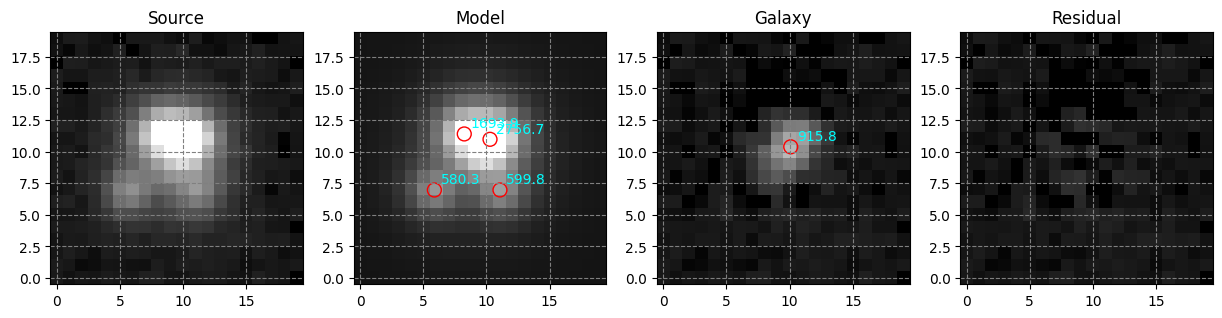

In [48]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(141)
norm = simple_norm(src.data, 'sqrt', percent=95.0)
ax1.imshow(src.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('Source')
ax2 = fig.add_subplot(142)
ax2.imshow(model_src(x, y), origin='lower', cmap='gray', norm=norm)
for model in model_src:
    if model.name.startswith('moffat'):
        ax2.scatter(model.x_0.value, model.y_0.value, s=100, edgecolor='red', facecolor='none')
        ax2.annotate(f"{model.amplitude.value:.1f}", (model.x_0.value+0.5, model.y_0.value+0.5), color='cyan')
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Model')
ax3 = fig.add_subplot(143)
galaxy = src.data - model_src[:-1](x, y)
ax3.imshow(galaxy, origin='lower', cmap='gray', norm=norm)
for model in model_src:
    if model.name.startswith('gaussian'):
        ax3.scatter(model.x_mean.value, model.y_mean.value, s=100, edgecolor='red', facecolor='none')
        ax3.annotate(f"{model.amplitude.value:.1f}", (model.x_mean.value+0.5, model.y_mean.value+0.5), color='cyan')
ax3.grid(True, color='gray', linestyle='--')
ax3.set_title('Galaxy')
ax4 = fig.add_subplot(144)
residual = src.data - model_src(x, y)
ax4.imshow(residual, origin='lower', cmap='gray', norm=norm)
ax4.grid(True, color='gray', linestyle='--')
ax4.set_title('Residual')
plt.show()

In [53]:
group

,source_id_smss,ra_smss,dec_smss,glon,glat,g_psf,e_g_psf,g_petro,e_g_petro,r_psf,...,source_id_wise,dist_wise2,ra_wise,dec_wise,w1mpro,w2mpro,w12mpro,w1mag,w2mag,w12mag
5559,30885280,110.677483,-39.033154,251.27299,-11.1353,18.5915,0.0196,18.5101,0.0273,18.2587,...,1103m394_b0-004438,5.913000e-10,110.677498,-39.033173,13.576,12.528,1.048,13.528,12.518,1.01
5560,30885280,110.677483,-39.033154,251.27299,-11.1353,18.5915,0.0196,18.5101,0.0273,18.2587,...,1103m394_b0-004438,5.913000e-10,110.677498,-39.033173,13.576,12.528,1.048,13.528,12.518,1.01
5561,30885280,110.677483,-39.033154,251.27299,-11.1353,18.5915,0.0196,18.5101,0.0273,18.2587,...,1103m394_b0-004438,5.913000e-10,110.677498,-39.033173,13.576,12.528,1.048,13.528,12.518,1.01
